In [1]:
%matplotlib inline

Install rendering libraries and gym

In [2]:
!pip3 install gymnasium

Import libraries


In [3]:
import gymnasium as gym
import nump keynotey as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import math
import random
import matplotlib
from collections import namedtuple
from itertools import count


Setup matplotlib to display the environment


In [13]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


**Acrobot**

The Acrobot environment is based on Sutton’s work in “Generalization in Reinforcement Learning: Successful Examples Using Sparse Coarse Coding” and Sutton and Barto’s book. The system consists of two links connected linearly to form a chain, with one end of the chain fixed. The joint between the two links is actuated. The goal is to apply torques on the actuated joint to swing the free end of the linear chain above a given height while starting from the initial state of hanging downwards. The goal is to swing the free end of the outer-link to reach the target height (black horizontal line above system) by applying torque on the actuator.

The CartPole task is designed so that the inputs to the agent are 4 real
values representing the observations (cosine, sine and angular velocity of each joint angle).

The action is discrete, deterministic, and represents the torque applied on the actuated joint between the two links.

The goal is to have the free end reach a designated target height in as few steps as possible, and as such all steps that do not reach the goal incur a reward of -1. Achieving the target height results in termination with a reward of 0. The reward threshold is -100.



Create the simulation environment and visualise

[ 0.9610934  -0.27622354  0.8480631   0.52989525  0.74236625 -1.1508628 ] -1.0 False False {}


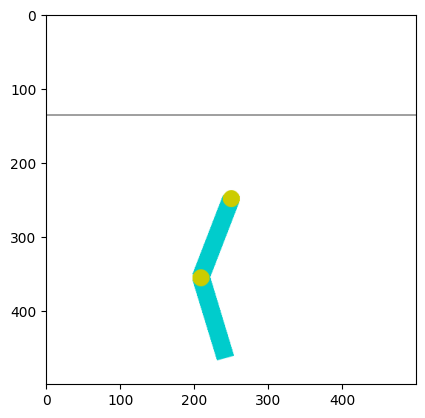

In [14]:
# 1. It renders instance for 20 timesteps, perform random actions

env = gym.make('Acrobot-v1',render_mode="rgb_array")
env.reset()
img = plt.imshow(env.render()) # only call this once
for _ in range(20):
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample() #choose a random action
    observation, reward, terminated, truncated, info = env.step(action) #observe the output of the environment
    print(observation, reward, terminated, truncated, info)


action_space & observation_space describe what is the valid format for that particular env to work on with. Just take a look at values returned.

In [7]:
#Action space
print(env.action_space)
print(env.action_space.n)

#Observation space
print(env.observation_space) #for cartpole : position,velocity, angle, angular velocity
print(env.observation_space.low, env.observation_space.high)

#reward function
print(env.reward_range)


Discrete(3)
3
Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
[ -1.        -1.        -1.        -1.       -12.566371 -28.274334] [ 1.        1.        1.        1.       12.566371 28.274334]
(-inf, inf)


Discrete means non-negative integer values. In the example above, 0 or 1 are equivalent to left and right movement for CartPole balancing. Box represent n-dim array. These can help in writing general codes for different environments. As we can simply check the bounds env.observation_space.high/[low] and code them into our general algorithm. You can read more about the cartpole environment in https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py


In [8]:
# 2. To check all env available, uninstalled ones are also shown
from gym import envs
print(envs.registry.all())

dict_values([EnvSpec(id='CartPole-v0', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='CartPole', version=0), EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='CartPole', version=1), EnvSpec(id='MountainCar-v0', entry_point='gym.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='MountainCar', version=0), EnvSpec(id='MountainCarContinuous-v0', entry_point='gym.envs.classic_control.co

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:421: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


# DQN
Let us now start implementing DQN.
We will use pytorch for the deep learning part, including :

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)


Let us import the necessary libraries.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

Setup matplotlib to display the environment


In [5]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

Use gpu if available

In [6]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Replay Memory
-------------

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the
   screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [7]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


DQN algorithm
-------------
First, let's quickly recap what a DQN is.

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we can use the mean square error. However, in practice, the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss> is more efficient. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

Q-network
-----------

Our model will be a convolutional neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and
$Q(s, \mathrm{right})$ (where $s$ is the input to the
network). In effect, the network is trying to predict the *expected return* of
taking each action given the current input.




Below is a pytorch implementation of a convolutional neural network with one layer of 2D convolution of kernel size 5 and stride 2, and a layer of normalization.

**Please complete the code to add twice layers of convolution (of kernel_size 5 and stride 2), normalization and ReLU.**
The first convolution produces 32 channels, and the second convolution produces 32 channels.
You can use PyTorch's predefined Conv2D classfor the convolutional layer (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) and BatchNorm2d (https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d) and the functions in https://pytorch.org/docs/stable/nn.functional.html


In [8]:
# COMPARE FLATTEN and VIEW
# Create (2, 3, 4) shape data tensor filled with 0.
a = torch.zeros(2, 3, 4)

# Flatten 2nd and 3rd dimensions of the original data
# tensor using `view` and `flatten` methods.
b = a.view(2, 12)
c = torch.flatten(a, start_dim=1)
print( a, b, c)

# Change a distinct value in each flattened tensor object.
b[0, 2] = 1
print( a, b, c)
c[0, 4] = 2
print( a, b, c)

print(a.size(0), a.size(1))

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]]) tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]) tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[[0., 0., 1., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]]) tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]) tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[[0., 0., 1., 0.],
         [2., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]]) tensor([[0., 0., 1., 0., 2., 0., 0

In [19]:
# TODO : complete the code for the structure of the neural network
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        # h is the image height
        # w is the image width
        # outputs is the the dimension of the output
        super(DQN, self).__init__()
        # TODO : complete code by setting the architecture of the neural network
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)


    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[exp after torque -1,exp after torque 0, exo after torque 1]...]).
    def forward(self, x):
        # TODO : complete code
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Training

### Hyperparameters and utilities
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the duration of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.




In [34]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
TARGET_UPDATE = 10


# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

##Training loop

Finally, the code for training our model.


**Implement in ``optimize_model`` function that performs a
single step of the optimization the code for :**
- **Compute V(s_{t+1}) for all next states**
-  **Compute the expected Q values**
-  **Compute Huber loss**

It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By defition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network has its weights kept frozen most of
the time, but is updated with the policy network's weights every so often.
This is usually a set number of steps but we shall use episodes for
simplicity.

The ``optimize_model`` corresponds to the follwing lines of the pseudo-code

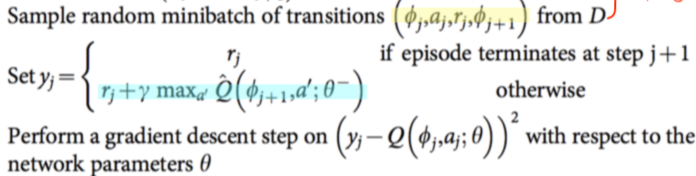


For training neural networks, you can refer to the following documentation:

* https://pytorch.org/docs/stable/nn.functional.html




<font color='red'> TODO: complete this function optimising Q-value to train with Huber loss </font>


In [35]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # TODO: Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # TODO: Compute the expected Q values
    #expected_state_action_values = 0
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # TODO : Compute Huber loss
    #loss = 0
    # Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    #MSE loss
    #loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad() #zeroes the gradient buffers of all parameters, so as not to accumulate to existing gradients
    loss.backward()       #backpropagate the error
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()      #does the update

<font color='red'> **Below, please implement the main training loop.**
At the beginning we reset
the environment and initialize the ``state`` Tensor. Then, we sample
an action, execute it, observe the next screen and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop. </font>

<font color='red'>Below, `num_episodes` is set small. You should download
the notebook and run lot more epsiodes, such as 300+ for meaningful
duration improvements.</font>

<font color='red'>
TODO: implement the training loop, with the action selection, updates of states and neural networks using Huber loss, and plot the evolution of the reward during training. </font>



Complete


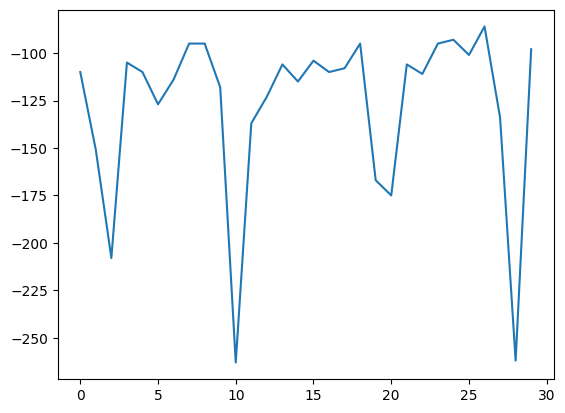

In [44]:
# TODO adapt the number of episodes
num_episodes = 30
rewards_list = []

#for each episode
for i_episode in range(num_episodes):
    reward_per_episode =0 # sum of rewards per episode
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():

        # TODO: Select, perform an action
        #and observe reward and new state
        action = select_action(state)

        # Observe new state
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward_per_episode += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # TODO : Move to the next state
        state = next_state

        # TODO : Perform one step of the optimization (on the target network)
        optimize_model()


        # TODO: Update the target network every TARGET_UPDATE episodes,
        # copying all weights and biases in DQN
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())


        if done:
            rewards_list.append(reward_per_episode)
            break

print('Complete')
plt.plot(rewards_list)
plt.show()


## WITH MSE LOSS

<font color='red'>
TODO: implement the training loop, with the action selection, updates of states and neural networks using Huber loss, and plot the evolution of the reward during training.

TODO: Compare MSE loss and Huber loss
</font>



Complete


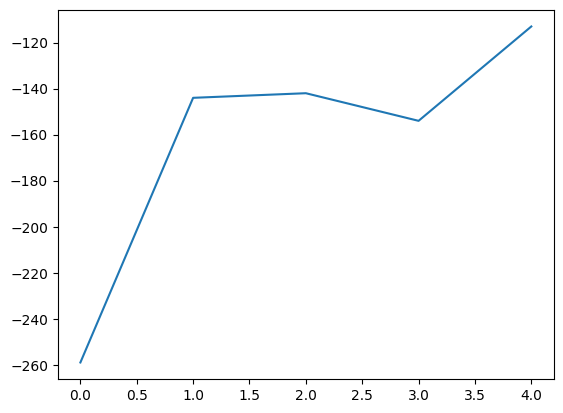

In [45]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # TODO: Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # TODO: Compute the expected Q values
    #expected_state_action_values = 0
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # TODO : Compute MSE loss
    #loss = 0
    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad() #zeroes the gradient buffers of all parameters, so as not to accumulate to existing gradients
    loss.backward()       #backpropagate the error
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()      #does the update


# TODO adapt the number of episodes
num_episodes = 30
rewards_list = []

#for each episode
for i_episode in range(num_episodes):
    reward_per_episode =0 # sum of rewards per episode
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():

        # TODO: Select, perform an action
        #and observe reward and new state
        action = select_action(state)

        # Observe new state
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward_per_episode += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # TODO : Move to the next state
        state = next_state

        # TODO : Perform one step of the optimization (on the target network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        # TODO: Update the target network every TARGET_UPDATE episodes,
        # copying all weights and biases in DQN
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())


        if done:
            rewards_list.append(reward_per_episode)
            break

print('Complete')
plt.plot(rewards_list)
plt.show()
